# Comparing M&M with atlas-qtl

See [here](20200110_atlasqtl_demo.html) for some background information. Since `atlas-qtl` does not give credible sets we compare here the marginal PIP in terms of calibration and precision-recall curves.

## The benchmark

The benchmark is executed locally because `mthess` can take very long time to complete.

```
./finemap.dsc --host dsc_mnm.yml -o mnm_20200124 --touch -e ignore
```

In [ ]:
[global]
parameter: cwd = path('/home/gaow/GIT/mvarbvs/dsc/mnm_prototype')
parameter: data_dir = 'mnm_20200124/'
parameter: date = '0302'
def fmtP(x):
    return str(x).replace(".", "p")

## PIP extraction

I'll for now only extract file names and get the values as needed after.

In [ ]:
# Extract meta info
[pip_1,roc_1]
output: f'{cwd}/{data_dir}/PIP_comparison_{date}.pips_meta.rds'
R: expand = '${ }', workdir = cwd
    meta = dscrutils::dscquery('mnm_20200124', target = c("full_data.dataset", "simulate.n_traits", "simulate.n_signal", "simulate", "method"), module.output.files=c("simulate", "method"), group = c("method: mnm_high_het mnm_mixture01 atlasqtl", "methods:"), ignore.missing.file=T)
    print(dim(meta))
    # remove bad files
    bad_files = vector()
    for (f in meta$method.output.file) {
      if (!file.exists(paste0("${data_dir}/", f,'.rds'))) bad_files = append(bad_files, f)
    }
    meta = meta[which(!(meta$method.output.file %in% bad_files)),]
    print(dim(meta))
    saveRDS(meta, ${_output:r})

In [3]:
%cd /home/gaow/GIT/mvarbvs/dsc/mnm_prototype/mnm_20200124

/project2/mstephens/gaow/mvarbvs/dsc/mnm_prototype/mnm_20200124

In [30]:
dat = readRDS('PIP_comparison_0302.pips_meta.rds')

In [31]:
head(dat)

DSC,full_data.dataset,simulate.n_traits,simulate.n_signal,simulate,method,full_data.output.file,simulate.output.file,method.output.file
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000003.14.Multi_Tissues.rds,5,-1,high_het,mnm_high_het,full_data/full_data_1,high_het/full_data_1_high_het_1,mnm_high_het/full_data_1_high_het_1_oracle_generator_1_mnm_high_het_1
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000005.5.Multi_Tissues.rds,5,-1,high_het,mnm_high_het,full_data/full_data_2,high_het/full_data_2_high_het_1,mnm_high_het/full_data_2_high_het_1_oracle_generator_1_mnm_high_het_1
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000419.12.Multi_Tissues.rds,5,-1,high_het,mnm_high_het,full_data/full_data_3,high_het/full_data_3_high_het_1,mnm_high_het/full_data_3_high_het_1_oracle_generator_1_mnm_high_het_1
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000457.13.Multi_Tissues.rds,5,-1,high_het,mnm_high_het,full_data/full_data_4,high_het/full_data_4_high_het_1,mnm_high_het/full_data_4_high_het_1_oracle_generator_1_mnm_high_het_1
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000460.16.Multi_Tissues.rds,5,-1,high_het,mnm_high_het,full_data/full_data_5,high_het/full_data_5_high_het_1,mnm_high_het/full_data_5_high_het_1_oracle_generator_1_mnm_high_het_1
1,~/Documents/GTExV8/Multi_Tissue_Toys/ENSG00000000938.12.Multi_Tissues.rds,5,-1,high_het,mnm_high_het,full_data/full_data_6,high_het/full_data_6_high_het_1,mnm_high_het/full_data_6_high_het_1_oracle_generator_1_mnm_high_het_1


In [9]:
unique(dat$simulate.n_traits)

[1]  5 10 50

In [ ]:
# Extract PIP
[pip_2,roc_2]
parameter: mnm_method = 'mnm_high_het+mnm_low_het'
parameter: simulate_method = 'high_het'
parameter: n_traits = 50
parameter: sub_set = 1200
output: f'{cwd}/{data_dir}/PIP_comparison_{date}.pips.{simulate_method}_{mnm_method}_{n_traits}_{sub_set}.rds'
R: expand = '${ }', workdir = f'{cwd}/{data_dir}'

    meta = readRDS(${_input:r})
    # apply some filters
    meta = meta[which(meta$method %in% c(${','.join([repr(x) for x in mnm_method.split('+')])}, 'atlasqtl') & meta$simulate == '${simulate_method}' & meta$simulate.n_traits == ${n_traits}),]
    if (${sub_set}<nrow(meta) && ${sub_set}>0) {
      set.seed(999)
      meta = meta[sample(1:nrow(meta))[1:${sub_set}],]
    }
    print(dim(meta))
    # now collect matrices for each method, of two columns: pip and true_coef
    res = list()
    for (i in 1:nrow(meta)) {
      true_coef = as.integer(dscrutils:::read_dsc(paste0(meta[i,]$simulate.output.file, '.pkl'))$meta$true_coef != 0)
      # make it a vector
      true_coef = c(true_coef)
      method = meta[i,]$method
      if (method == "atlasqtl") {
          pip = dscrutils:::read_dsc(paste0(meta[i,]$method.output.file, '.rds'))$result$gam_vb_completed
      } else {
          tmp = dscrutils:::read_dsc(paste0(meta[i,]$method.output.file, '.rds'))$result
          # approximate PIP using condition specific 1 - lfsr
          pip = 1 - mmbr::mmbr_get_lfsr(tmp)
      }
      # PIP is matrix of P (SNPs) by R (conditions); now make it a vector
      pip = c(pip)
      if (!(method %in% names(res))) {
        res[[method]] = list(pip = pip, truth = true_coef)
      } else {
        res[[method]]$pip = append(res[[method]]$pip, pip)
        res[[method]]$truth = append(res[[method]]$truth, true_coef)
      }
      if (i%%100==0) print(i)
    }
    for (method in unique(meta$method)) {
      res[[method]] = do.call(cbind, res[[method]])
    }
    saveRDS(res, ${_output:r})

In [12]:
dat = readRDS("PIP_comparison_0302.pips.high_het_mnm_high_het+mnm_low_het_50_500.rds")
names(dat)

[1] "mnm_high_het" "atlasqtl"

Now let's peep into the result:

In [14]:
head(dat$atlasqtl)

pip,truth
4.097906e-05,0
2.606266e-05,0
3.117386e-05,0
3.306454e-05,0
4.816789e-05,0
3.272972e-05,0


In [21]:
head(dat$atlasqtl[which(dat$atlasqtl[,2]==1),])

pip,truth
3.209868e-05,1
2.472211e-05,1
4.558600e-07,1
2.115187e-05,1
4.447844e-06,1
3.126282e-05,1


In [24]:
colSums(dat$atlasqtl[which(dat$atlasqtl[,2]==1),])

pip       truth 
   4.514973 4950.000000

It seems atlasqtl somehow missed almost all signals? Let's see how M&M works

In [16]:
head(dat$mnm_high_het)

pip,truth
0,0
0,0
0,0
0,0
0,0
0,0


In [25]:
head(dat$mnm_high_het[which(dat$mnm_high_het[,2]==1),])

pip,truth
0.9105833,1
0.9105833,1
0.9105833,1
0.9105833,1
0.9105833,1
0.9105833,1


In [26]:
colSums(dat$mnm_high_het[which(dat$mnm_high_het[,2]==1),])

pip    truth 
18997.46 37150.00

This seems reasonable.

## Looking into issues with atlasqtl

Take one run for example:

In [2]:
dat = readRDS('atlasqtl/full_data_100_high_het_1_atlasqtl_1.rds')
names(dat$result)

[1] "beta_vb"     "gam_vb"      "theta_vb"    "X_beta_vb"   "zeta_vb"    
 [6] "converged"   "it"          "lb_opt"      "diff_lb"     "p0"         
[11] "rmvd_coll_x" "pip"

In [33]:
dim(dat$result$gam_vb)

[1] 1479    5

Now check the corresponding input file:

In [3]:
idat = readRDS('full_data/full_data_100.rds')
dim(idat$X)

[1]  838 2446

There are 2466 variables in input, but only 1479 in output of `atlasqtl`! Let's run the code and see what happens:

In [34]:
cat(dat$DSC_DEBUG$script)

## r script UUID: 97106506
library(atlasqtl)
DSC_22B90227 <- list()
DSC_22B90227 <- dscrutils:::load_inputs(c('mnm_20200124/full_data/full_data_100.rds','mnm_20200124/high_het/full_data_100_high_het_1.pkl'), dscrutils:::read_dsc)
DSC_REPLICATE <- DSC_22B90227$DSC_DEBUG$replicate
X <- DSC_22B90227$X
Y <- DSC_22B90227$Y
meta <- DSC_22B90227$meta
TIC_22B90227 <- proc.time()
set.seed(DSC_REPLICATE)

## BEGIN DSC CORE
library(atlasqtl)
pat = meta$true_coef != 0
p0 = c(mean(colSums(pat)), 10)
result = atlasqtl::atlasqtl(Y = Y, X = X, p0 = p0, user_seed = DSC_REPLICATE)
result$pip = as.vector(1 - apply(1 - result$gam_vb, 1, prod))
## END DSC CORE

saveRDS(list(result=result, DSC_DEBUG=dscrutils:::save_session(TIC_22B90227, DSC_REPLICATE)), 'mnm_20200124/atlasqtl/full_data_100_high_het_1_atlasqtl_1.rds')




In [4]:
library(atlasqtl)
DSC_22B90227 <- list()
DSC_22B90227 <- dscrutils:::load_inputs(c('full_data/full_data_100.rds','high_het/full_data_100_high_het_1.pkl'), dscrutils:::read_dsc)
DSC_REPLICATE <- DSC_22B90227$DSC_DEBUG$replicate
X <- DSC_22B90227$X
Y <- DSC_22B90227$Y
meta <- DSC_22B90227$meta
TIC_22B90227 <- proc.time()
set.seed(DSC_REPLICATE)

## BEGIN DSC CORE
library(atlasqtl)
pat = meta$true_coef != 0
p0 = c(mean(colSums(pat)), 10)
result = atlasqtl::atlasqtl(Y = Y, X = X, p0 = p0, user_seed = DSC_REPLICATE)


== PREPROCESSING ... == 

== Checking the annealing schedule ... 

... done. == 

== Preparing the data ... 

Presence of collinear variables. 967 redundant.
Removing corresponding columns and saving their ids in the function output ... 
... done. == 

== Preparing the hyperparameters ... 

list_hyper set automatically. 
... done. == 

== Preparing the parameter initialization ... 

Seed set to user_seed 1. 
list_init set automatically. 
... done. == 

**************************************************** 
Number of samples: 838
Number of (non-redundant) candidate predictors: 1479
Number of responses: 5
**************************************************** 

== ATLASQTL: fast global-local hotspot QTL detection == 

** Annealing with geometric spacing ** 

Iteration 1... 
Temperature = 2

Iteration 5... 
Temperature = 1.47

** Exiting annealing mode. **

Iteration 10... 
ELBO = -2230.541

Iteration 50... 
ELBO = -1999.938

Convergence obtained after 51 iterations. 
Optimal marginal log-l

And here is the problem:

```
== Preparing the data ... 

Presence of collinear variables. 967 redundant.
Removing corresponding columns and saving their ids in the function output ... 
... done. == 
```

967 redundant variables removed plus 1479 remaining is 2446 variables.

**For results to be comparable we'll have to either preprocess input removing these collinear variables before we run M&M, or somehow (perhaps impossible?) post process the PIPs from atlasqtl to recover the actual expected PIP**. Or, we contact the authors to clarify it ...

Documentation for `atlasqtl`:

In [ ]:
?atlasqtl::atlasqtl

Now the question is how "collinear" those SNPs are.

In [5]:
names(result)

[1] "beta_vb"     "gam_vb"      "theta_vb"    "X_beta_vb"   "zeta_vb"    
 [6] "converged"   "it"          "lb_opt"      "diff_lb"     "p0"         
[11] "rmvd_coll_x"

In [7]:
head(result$rmvd_coll_x)

chr7_86482150_T_A_b38       chr7_86482150_T_A_b38 
"chr7_86482210_GAAGA_G_b38"     "chr7_86482300_A_T_b38" 
      chr7_86484748_C_T_b38       chr7_86485238_G_A_b38 
    "chr7_86485234_T_C_b38"     "chr7_86485290_C_A_b38" 
      chr7_86483690_A_G_b38       chr7_86483690_A_G_b38 
    "chr7_86485763_G_A_b38"     "chr7_86486045_A_G_b38"

In [16]:
coll_x = cbind(names(result$rmvd_coll_x), result$rmvd_coll_x)
head(coll_x)

chr7_86482150_T_A_b38,chr7_86482150_T_A_b38,chr7_86482210_GAAGA_G_b38
chr7_86482150_T_A_b38,chr7_86482150_T_A_b38,chr7_86482300_A_T_b38
chr7_86484748_C_T_b38,chr7_86484748_C_T_b38,chr7_86485234_T_C_b38
chr7_86485238_G_A_b38,chr7_86485238_G_A_b38,chr7_86485290_C_A_b38
chr7_86483690_A_G_b38,chr7_86483690_A_G_b38,chr7_86485763_G_A_b38
chr7_86483690_A_G_b38,chr7_86483690_A_G_b38,chr7_86486045_A_G_b38


In [19]:
cor_x = vector()
for (i in 1:nrow(coll_x)) {
    cor_x[i] = cor(X[,coll_x[i,1]], X[,coll_x[i,2]])
}

summary(cor_x)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1       1       1       1       1       1 

So indeed only the ones with perfect correlation are removed.

**Update: I have now added a post-processing function to atlasqtl to report back PIP avarged among co-linear input. See `pip_2` above.**

## PIP calibration

In [ ]:
# Calibration and ROC data
[pip_3]
parameter: bin_size = 20
output: f'{_input:nn}.pip_evaluation.rds'
R: expand = '${ }', workdir = cwd
  dat = readRDS(${_input:r})
  bins = cbind(seq(1:${bin_size})/${bin_size}-1/${bin_size}, seq(1:${bin_size})/${bin_size})
  pip_cali = list()
  for (method in names(dat)) {
      pip_cali[[method]] = matrix(NA, nrow(bins), 3)
      for (i in 1:nrow(bins)) {
        data_in_bin = dat[[method]][which(dat[[method]][,1] > bins[i,1] & dat[[method]][,1] < bins[i,2]),]
        pip_cali[[method]][i,1] = sum(data_in_bin[,1])
        pip_cali[[method]][i,2] = sum(data_in_bin[,2])
        pip_cali[[method]][i,3] = nrow(data_in_bin)
      }
  }
  for (method in names(dat)) {
      pip_cali[[method]][,c(1,2)] = pip_cali[[method]][,c(1,2)] / pip_cali[[method]][,3]
  }
  saveRDS(pip_cali, ${_output:r})

In [ ]:
# Calibration plot
[pip_4]
depends: R_library('cowplot')
output: f'{_input:nn}.pip_evaluation.png'
R: expand = '${ }', workdir = cwd
    library(ggplot2)
    library(cowplot)
    rename = list(mnm_high_het = 'M&M (oracle)', mnm_mixture01 = 'M&M (default)', mthess = 'MT-HESS (default)', atlasqtl = 'atlasqtl')
    dot_plot = function(dataframe) {
        ggplot(dataframe, aes(x=mean_pip, y=observed_freq)) + 
          geom_errorbar(aes(ymin=observed_freq-se, ymax=observed_freq+se), colour="gray", size = 0.2, width=.01) +
          geom_point(size=1.5, shape=21, fill="#002b36") + # 21 is filled circle
          xlab("Mean PIP") +
          ylab("Observed frequency") +
          coord_cartesian(ylim=c(0,1), xlim=c(0,1)) +
          geom_abline(slope=1,intercept=0,colour='red', size=0.2) +
          ggtitle(rename[[name]]) +
          expand_limits(y=0) +                        # Expand y range
          theme_cowplot()
    }
    dat = readRDS(${_input:r})
    idx = 0
    for (name in names(dat)) {
      idx = idx + 1
      dat[[name]][,3] = sqrt(dat[[name]][,2] * (1 - dat[[name]][,2]) / dat[[name]][,3]) * 2
      dat[[name]] = as.data.frame(dat[[name]])
      colnames(dat[[name]]) = c("mean_pip", "observed_freq", "se")
      pdf(paste0(${_output:nr}, '_' , idx, '.pdf'), width=3, height=3, pointsize=16)
      print(dot_plot(dat[[name]]))
      dev.off()
      system(paste0("convert -density 120 ", ${_output:nr}, '_' , idx, '.pdf', " ", ${_output:nr}, '_' , idx, '.png'))
    }
    files = paste0(${_output:nr}, '_', seq(1:idx), '.png')
    cmd = paste('convert +append', paste(files, collapse=" "), ${_output:r})
    system(cmd)
    system(paste('rm -f', paste(files, collapse=" ")))

> PIP_comparison_0302.pips.pip_evaluation.png (27.9 KiB):

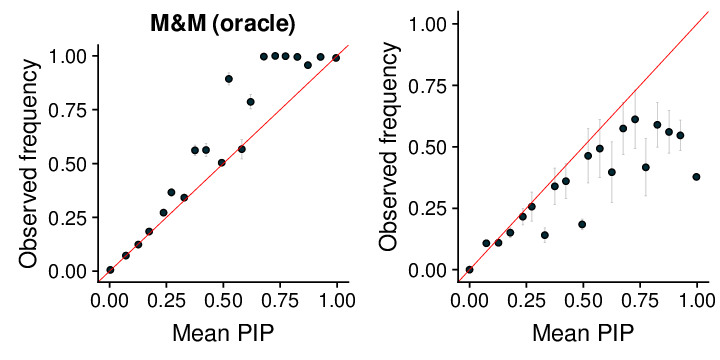

In [5]:
%preview PIP_comparison_0302.pips.pip_evaluation.png

## ROC / PR curves

In [ ]:
# Data for ROC
[roc_3]
pip_cutoff = 0.05
output: f'{_input:nn}.roc.rds'
R: expand = '${ }', workdir = cwd
    roc_data = function(d1, cutoff = c(${pip_cutoff}, 0.999), connect_org = T) {
        grid = 500
        ttv = seq(1:grid)/grid
        ttv = ttv[which(ttv>=cutoff[1] & ttv<=cutoff[2])]
        rst1 = t(sapply(ttv, function(x) c(sum(d1[,2][d1[,1]>=x]), length(d1[,2][d1[,1]>=x]))))
        rst1 = cbind(rst1, sum(d1[,2]))
        rst1 = as.data.frame(rst1)
        colnames(rst1) = c('true_positive', 'total_positive', 'total_signal')
        rst2 = as.data.frame(cbind(rst1$true_positive / rst1$total_positive, rst1$true_positive / rst1$total_signal,  ttv))
        if (connect_org) {
            # make a stair to origin
            rst2 = rbind(rst2, c(max(0.995, rst2[nrow(rst2),1]), max(rst2[nrow(rst2),2]-0.01, 0), rst2[nrow(rst2),3]))
            rst2 = rbind(rst2, c(1, 0, 1))
        }
        colnames(rst2) = c('Precision', 'Recall', 'Threshold')
        return(list(counts = rst1, rates = rst2))
    }

    print("Computing ROC data ...")
    roc = list()
    dat = readRDS(${_input:r})
    for (method in names(dat)) {
      roc[[method]] = roc_data(dat[[method]])
    }
    saveRDS(roc, ${_output:r})

In [7]:
dat = readRDS('/home/gaow/GIT/mvarbvs/dsc/mnm_prototype/mnm_20200124/PIP_comparison_0302.pips.roc.rds')
names(dat)

[1] "mnm_high_het" "atlasqtl"

In [ ]:
# Plot for ROC
[roc_4]
depends: R_library('scam')
parameter: chunks = 0
parameter: smooth = 'FALSE'
parameter: opt = "lwd = 2, xlim = c(0,0.8), ylim = c(0,0.8)"
parameter: main = "FDR vs Power"
output: f'{_input:nn}.roc.pdf'
R: expand = '${ }'
    colors = c('#A60628', '#7A68A6', '#348ABD', '#467821', '#FF0000', '#188487', '#E2A233',
                  '#A9A9A9', '#000000', '#FF00FF', '#FFD700', '#ADFF2F', '#00FFFF')
    dat = readRDS(${_input:r})
    library(scam)
    create_chunks = function(item, n) {
      splitted = suppressWarnings(split(item, 1:n))
      return(c(splitted[[1]], splitted[[length(splitted)]][length(splitted[[length(splitted)]])]))
    }
    make_smooth = function(x,y,subset=${chunks}, smooth = ${smooth}) {
      if (smooth) {
          if (subset < length(x) && subset > 0) {
              x = create_chunks(x, subset)
              y = create_chunks(y, subset)
          }
          dat = data.frame(cbind(x,y))
          colnames(dat) = c('x','y')
          y=predict(scam(y ~ s(x, bs = "mpi"), data = dat))
      }
      return(list(x=x,y=y))
    }
    add_text = function(thresholds, x, y, threshold, color, delta = -0.06) {
        idx = which(thresholds == threshold)
        text(x[idx] - delta, y[idx], labels = threshold, col = color, cex=0.8)
        points(x[idx],y[idx])
    }
    rename = list(mnm_high_het = 'M&M (oracle)', mnm_mixture01 = 'M&M (default)', mthess = 'MT-HESS (default)', atlasqtl = 'atlasqtl (default)')
    labels = vector()
    pdf(${_output:r}, width=5, height=5, pointsize=15)
    i = 1
    for (method in names(dat)) {
        yy = make_smooth(1 - dat[[method]]$rates$Precision, dat[[method]]$rates$Recall)
        if (i == 1) {
            plot(yy$x, yy$y, t="l", col=colors[i], ylab = "power", xlab ="FDR", main = "${main}", bty='l', ${opt})
        } else {
            lines(yy$x, yy$y, col=colors[i], ${opt})
        }
        #add_text(dat[[method]]$rates$Threshold, yy$x, yy$y, 0.9, colors[i])
        add_text(dat[[method]]$rates$Threshold, yy$x, yy$y, 0.95, colors[i])
        labels[i] = rename[[method]]
        i = i + 1
    }
    legend("bottomright", legend=labels, col=colors[1:i], lty=c(1,1,1), cex=0.8)
    dev.off()

> PIP_comparison_0302.pips.roc.pdf (8.7 KiB):

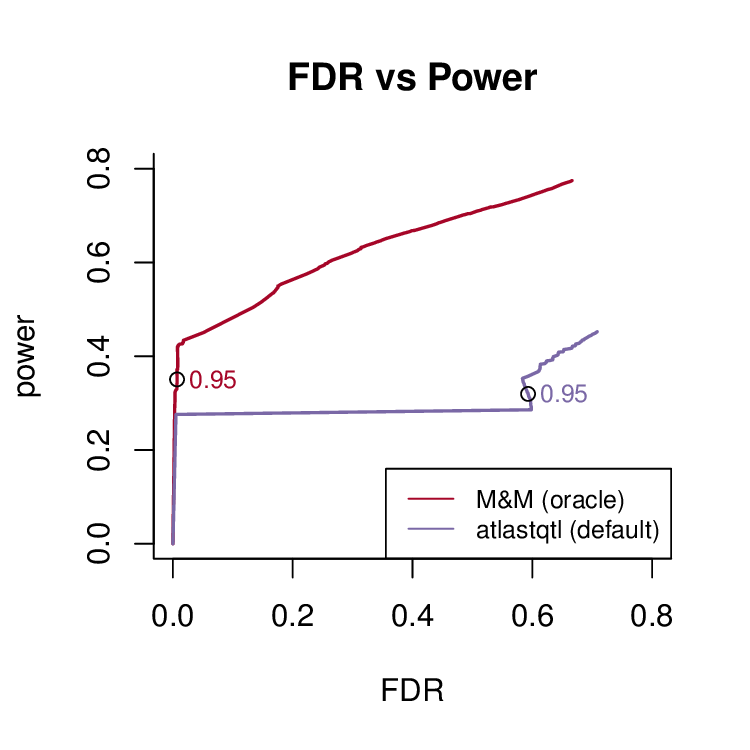

In [4]:
%preview PIP_comparison_0302.pips.roc.pdf -s png